# check package

In [1]:
import openvino as ov
print(ov.__version__)

2024.2.0-15519-5c0f38f83f6-releases/2024/2


In [2]:
import pkg_resources

package_name = "openvino-dev"
try: 
    distribution = pkg_resources.get_distribution(package_name)
    version = distribution.version
    print(f"{package_name} version: {version}")
except pkg_resources.DistributionNotFound: 
    print(f"{package_name} is not installed.")


openvino-dev is not installed.


C:\Users\user\AppData\Local\Temp\ipykernel_10216\1823579097.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


# OMZ download

In [3]:
! omz_downloader -h

usage: omz_downloader [-h] [--name PAT[,PAT...]] [--list FILE.LST] [--all]
                      [--print_all] [--precisions PREC[,PREC...]] [-o DIR]
                      [--cache_dir DIR] [--num_attempts N]
                      [--progress_format {text,json}] [-j N]

options:
  -h, --help            show this help message and exit
  --name PAT[,PAT...]   download only models whose names match at least one of
                        the specified patterns
  --list FILE.LST       download only models whose names match at least one of
                        the patterns in the specified file
  --all                 download all available models
  --print_all           print all available models
  --precisions PREC[,PREC...]
                        download only models with the specified precisions
                        (actual for DLDT networks); specify one or more of:
                        FP16-INT1,FP32-INT1,FP32,FP32-INT8,FP16,FP16-INT8
  -o DIR, --output_dir DIR
             

In [4]:
! omz_downloader --print_all

aclnet
aclnet-int8
action-recognition-0001
age-gender-recognition-retail-0013
anti-spoof-mn3
asl-recognition-0004
background-matting-mobilenetv2
bert-base-ner
bert-large-uncased-whole-word-masking-squad-0001
bert-large-uncased-whole-word-masking-squad-emb-0001
bert-large-uncased-whole-word-masking-squad-int8-0001
bert-small-uncased-whole-word-masking-squad-0001
bert-small-uncased-whole-word-masking-squad-0002
bert-small-uncased-whole-word-masking-squad-emb-int8-0001
bert-small-uncased-whole-word-masking-squad-int8-0002
brain-tumor-segmentation-0002
cocosnet
colorization-siggraph
colorization-v2
common-sign-language-0001
common-sign-language-0002
convnext-tiny
ctdet_coco_dlav0_512
ctpn
deeplabv3
densenet-121-tf
detr-resnet50
dla-34
driver-action-recognition-adas-0002
drn-d-38
efficientdet-d0-tf
efficientdet-d1-tf
efficientnet-b0
efficientnet-b0-pytorch
efficientnet-v2-b0
efficientnet-v2-s
emotions-recognition-retail-0003
erfnet
f3net
face-detection-0200
face-detection-0202
face-detectio

# Load model

In [11]:
import openvino as ov

core = ov.Core()
model = core.read_model(model=r'models/face-detection-adas-0001.xml') 
compiled_model = core.compile_model (model = model, device_name="CPU")

input_layer = compiled_model.input(0) 
output_layer = compiled_model.output(0)
print("Input shape:", input_layer.shape) 
print("Output shape:", output_layer.shape)

Input shape: [1,3,384,672]
Output shape: [1,1,200,7]


# New input data 
## call image


In [12]:
import os

file_path = "qwq.jpg"
print(os.path.isfile(file_path))  # 파일이 존재하는지 확인


False


(5760, 3840, 3)


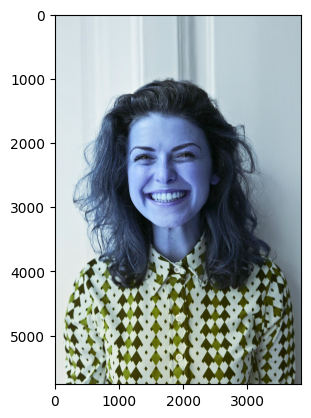

In [13]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("data/qwq.jpg")
print(image.shape)
plt.imshow(image)

In [14]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread("data/qwq.jpg") 
print (image. shape)
#plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

image_height, image_width, image_channels = image. shape
image = cv2.resize(image, (int (image_width/5), int (image_height/5)))
print (image. shape)

cv2.imshow("Image", image)
cv2.waitKey()
cv2.destroyAllWindows()

(5760, 3840, 3)
(1152, 768, 3)


In [15]:
image_height, image_width, image_channels = image.shape
image = cv2.resize(image, (int (image_width/5), int (image_height/5)))
print (image. shape)

cv2.imshow("Resized Image", image)
cv2.waitKey()
cv2.destroyAllWindows()

(230, 153, 3)


# Perprocess data


In [16]:
import numpy as np
def preprocess(image):
    N, input_channels, input_height, input_width = input_layer.shape
    
    resized_image = cv2.resize(image, (input_width, input_height))
    transposed_image = resized_image.transpose(2,0,1)
    input_image = np. expand_dims(transposed_image, 0)
    
    return input_image
    

In [19]:
input_image = preprocess(image)

# Run Inference

In [20]:
results = compiled_model([input_image])[output_layer]
print(results.shape)
results = np.squeeze(results)
print(np.shape(results))
print(results)
print(results[0])
print(np.round(results[0],2))


(1, 1, 200, 7)
(200, 7)
[[ 0.          1.          0.99994516 ...  0.2730318   0.6298907
   0.56825244]
 [ 0.          1.          0.023872   ...  0.5658578   0.350445
   0.70812887]
 [ 0.          1.          0.02323696 ... -0.05995994  0.54376644
   0.264778  ]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[0.         1.         0.99994516 0.2875022  0.2730318  0.6298907
 0.56825244]
[0.   1.   1.   0.29 0.27 0.63 0.57]


# Postprocess

In [21]:
def find_faceboxes(image, results, confidence_threshold):
    results = results.squeeze()
    
    scores = results[:,2]
    boxes = results[:,-4:]
    
    face_boxes = boxes[scores >= confidence_threshold]
    scores = scores[scores >= confidence_threshold]
    
    image_h, image_w, image_channels = image.shape
    face_boxes = face_boxes*np.array([image_w, image_h, image_w, image_h])
    face_boxes = face_boxes.astype(np.int64)
    
    return face_boxes, scores

In [22]:
confidence_threshold = .95
face_boxes, scores = find_faceboxes(image, results, confidence_threshold)
print(face_boxes)
print(scores)

[[ 43  62  96 130]]
[0.99994516]


In [23]:
def draw_faceboxes(image, face_boxes, scores):
    show_image = image.copy()
    
    for i in range(len(face_boxes)):
        
        xmin, ymin, xmax, ymax = face_boxes[i]
        cv2.rectangle(img=show_image, pt1=(xmin,ymin), pt2=(xmax,ymax), color=(0,200,0),thickness=2)
                      
    return show_image

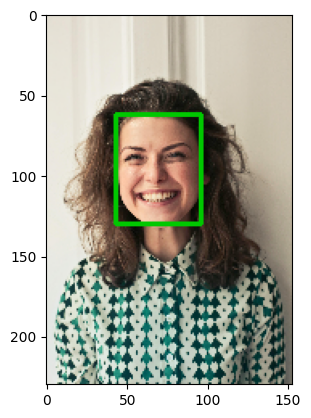

In [24]:
show_image = draw_faceboxes(image, face_boxes, scores)

plt.imshow(cv2.cvtColor(show_image, cv2.COLOR_BGR2RGB))

In [26]:
cv2.imshow("Image", show_image)
cv2.waitKey()
cv2.destroyAllWindows()

In [18]:
! omz_downloader --name emotions-recognition-retail-0003 --precision FP16

################|| Downloading emotions-recognition-retail-0003 ||################

========== Downloading D:\LJH\intel\emotions-recognition-retail-0003\FP16\emotions-recognition-retail-0003.xml
... 100%, 54 KB, 289 KB/s, 0 seconds passed

========== Downloading D:\LJH\intel\emotions-recognition-retail-0003\FP16\emotions-recognition-retail-0003.bin
... 21%, 1024 KB, 1040 KB/s, 0 seconds passed
... 42%, 2048 KB, 1725 KB/s, 1 seconds passed
... 63%, 3072 KB, 2210 KB/s, 1 seconds passed
... 84%, 4096 KB, 2730 KB/s, 1 seconds passed
... 100%, 4848 KB, 3013 KB/s, 1 seconds passed

